In [138]:
import load_recommender_data
import os
import time
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [139]:
path_in_str = 'data/user_data.json'
df_merge, anime_df, user_df = load_recommender_data.load_recommender_data(
    path_in_str)
df_merge.columns

/home/rythm/Courses/CS685/project/Codagami_Anime_Recommender/load_recommender_data.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  user_df = melt_series(df.data).to_frame().join(df.drop('data', 1))
/home/rythm/Courses/CS685/project/Codagami_Anime_Recommender/env/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/rythm/Courses/CS685/project/Codagami_Anime_Recommender/load_recommender_data.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Index(['anime_id', 'name', 'genre', 'episodes', 'rating_x', 'members',
       'user_id', 'rating_y'],
      dtype='object')

In [140]:
df_anime = anime_df[['anime_id', 'title']]
df_anime = df_anime.astype({'anime_id': int, 'title': str})
df_anime.reset_index(inplace=True)
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13442 entries, 0 to 13441
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     13442 non-null  object
 1   anime_id  13442 non-null  int64 
 2   title     13442 non-null  object
dtypes: int64(1), object(2)
memory usage: 315.2+ KB


In [141]:
df_ratings = df_merge[['user_id', 'anime_id', 'rating_y']].copy()
df_ratings = df_ratings.rename({'rating_y': 'rating'}, axis=1)
df_ratings = df_ratings.astype({'anime_id': int, 'user_id': int, 'rating': float})
df_ratings.reset_index(inplace=True)
df_ratings.info()
df_ratings['rating'] = ((df_ratings['rating'] / 10.0)*4.0) + 1
df_ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49730 entries, 0 to 49729
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     49730 non-null  int64  
 1   user_id   49730 non-null  int64  
 2   anime_id  49730 non-null  int64  
 3   rating    49730 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1.5 MB


,index,user_id,anime_id,rating
0,0,1,1,1.0
1,1,2,1,3.8
2,2,3,1,5.0
3,3,5,1,4.2
4,4,6,1,5.0


In [142]:
df_ratings_cnt_tmp = pd.DataFrame(
    df_ratings.groupby('rating').size(), columns=['count'])
total_cnt = len(df_ratings.user_id.unique()) * len(df_ratings.anime_id.unique())
rating_zero_cnt = total_cnt - df_ratings.shape[0]
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt


,count
0.0,528862
1.0,19085
1.4,342
1.8,574
2.2,758
2.6,1183
3.0,2195
3.4,3584
3.8,6918
4.2,7252


Text(0, 0.5, 'number of ratings')

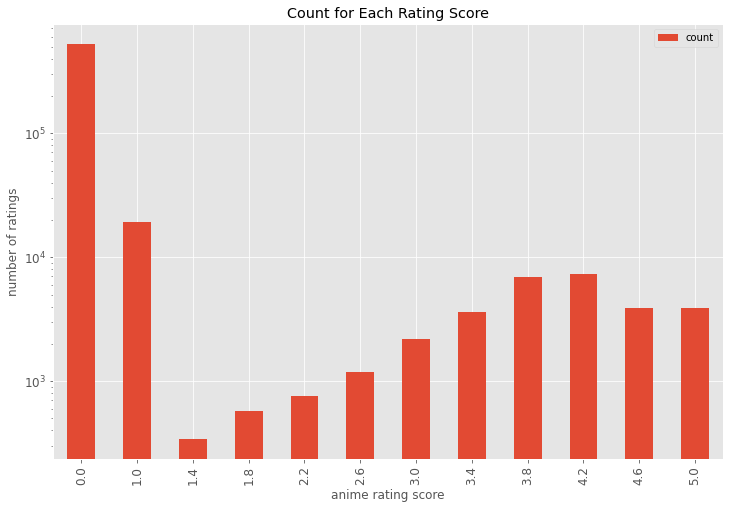

In [143]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("anime rating score")
ax.set_ylabel("number of ratings")

shape of original ratings data:  (49730, 4)
shape of ratings data after dropping unpopular animes:  (43053, 4)


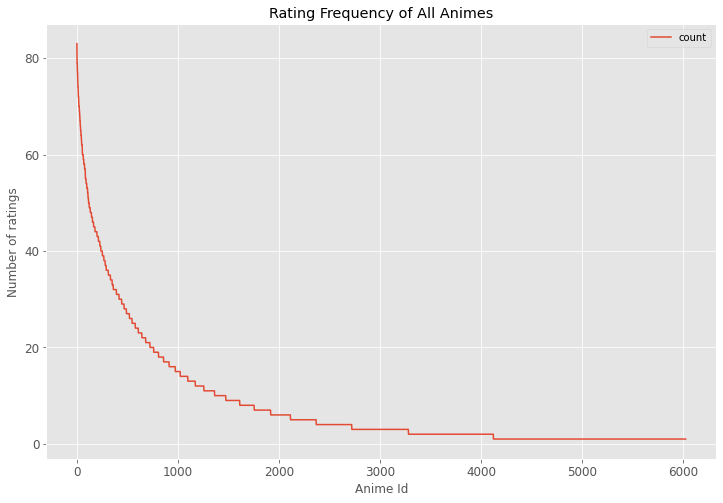

In [144]:
# get rating frequency
df_animes_cnt = pd.DataFrame(df_ratings.groupby('anime_id').size(), columns=['count'])
ax = df_animes_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Animes',
        fontsize=12
    )
ax.set_xlabel("Anime Id")
ax.set_ylabel("Number of ratings")
ax.get_figure().savefig('outputs/Rating_Frequency_of_Animes.jpeg')
# filter data
popularity_thres = 5
popular_animes = list(set(df_animes_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_animes = df_ratings[df_ratings.anime_id.isin(popular_animes)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular animes: ', df_ratings_drop_animes.shape)

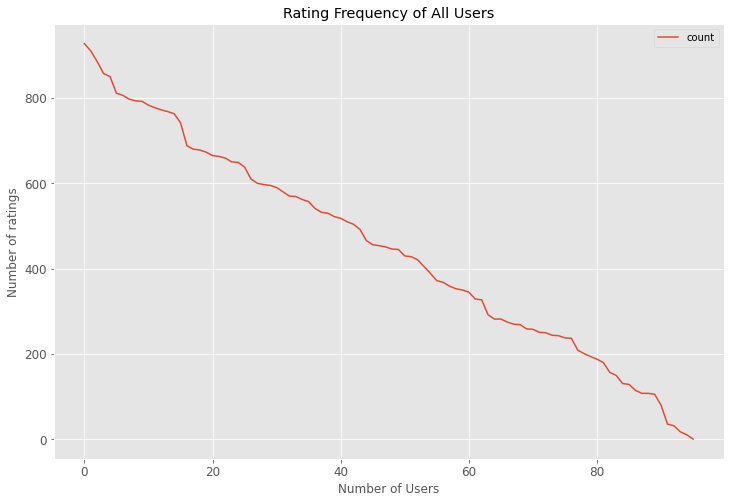

In [145]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_animes.groupby('user_id').size(), columns=['count'])
# plot rating frequency of all animes
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("Number of Users")
ax.set_ylabel("Number of ratings")
ax.get_figure().savefig('outputs/Rating_Frequency_of_Users.jpeg')
# filter data
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_animes[df_ratings_drop_animes.user_id.isin(active_users)]
# print('shape of original ratings data: ', df_ratings.shape)
# print('shape of ratings data after dropping both unpopular animes and inactive users: ', df_ratings_drop_users.shape)

In [146]:
# pivot and create anime-user matrix
anime_user_mat = df_ratings_drop_users.pivot(index='anime_id', columns='user_id', values='rating').fillna(0)
# create mapper from anime title to index
anime_to_idx = {
    anime: i for i, anime in 
    enumerate(list(df_anime.set_index('anime_id').loc[anime_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
anime_user_mat_sparse = csr_matrix(anime_user_mat.values)

In [147]:
%env JOBLIB_TEMP_FOLDER=/tmp
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(anime_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [148]:
def fuzzy_matching(mapper, fav_anime, verbose=True):
    match_tuple = []
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_anime.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_anime, n_recommendations):
    model_knn.fit(data)
    print('You have input anime:', fav_anime)
    idx = fuzzy_matching(mapper, fav_anime, verbose=True)
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    reverse_mapper = {v: k for k, v in mapper.items()}
    print('Recommendations for {}:'.format(fav_anime))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [149]:
my_favorite = 'Cowboy Bebop'

make_recommendation(
    model_knn=model_knn,
    data=anime_user_mat_sparse,
    fav_anime=my_favorite,
    mapper=anime_to_idx,
    n_recommendations=10)

You have input anime: Cowboy Bebop
Found possible matches in our database: ['Cowboy Bebop']

Recommendation system start to make inference
......

Recommendations for Cowboy Bebop:
1: FLCL, with distance of 0.31903903051406135
2: Akira, with distance of 0.31690885637703625
3: Monster, with distance of 0.3168795683168413
4: Samurai Champloo, with distance of 0.3042900227126648
5: Bleach, with distance of 0.30396440374767253
6: Cowboy Bebop: Tengoku no Tobira, with distance of 0.30382183444633903
7: Neon Genesis Evangelion: The End of Evangelion, with distance of 0.30313470443520196
8: Death Note, with distance of 0.28743321445921133
9: Fullmetal Alchemist: Brotherhood, with distance of 0.28349179908653377
10: Neon Genesis Evangelion, with distance of 0.28263286514808483


In [150]:
ratio_zeros = ( (anime_user_mat==0).sum(axis=1).sum()) / (anime_user_mat.shape[0] * anime_user_mat.shape[1])
print('{:.2%} of ratings is missing'.format(ratio_zeros))

80.87% of ratings is missing
